In [107]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

In [108]:
trf_score_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_scores.csv"))
trf_scores = pd.concat([pd.read_csv(p) for p in trf_score_paths],
                       keys=[(p.parents[2].name, p.parents[1].name) for p in trf_score_paths],
                       names=["model", "equivalence"]).reset_index(level=2, drop=True)
trf_scores = trf_scores.reset_index().melt(id_vars=["model", "equivalence", "fold"], var_name="output_dim", value_name="score").dropna()

trf_scores["model"] = trf_scores.model.str.replace("random[^_]*_", "", regex=True)

trf_scores

,model,equivalence,fold,output_dim,score
0,w2v2_6_8,random,0,0,0.113704
1,w2v2_6_8,random,1,0,0.104900
2,w2v2_6_8,random,2,0,0.105898
3,w2v2_6_3,phoneme,0,0,0.543263
4,w2v2_6_3,phoneme,1,0,0.539412
...,...,...,...,...,...
1411,w2v2_6_32,phoneme_within_word_prefix,1,31,0.642783
1412,w2v2_6_32,phoneme_within_word_prefix,2,31,0.651855
1413,w2v2_6_32,phoneme_within_word_suffix,0,31,0.622460
1414,w2v2_6_32,phoneme_within_word_suffix,1,31,0.614575


In [109]:
score_summary = trf_scores.groupby(["model", "equivalence", "fold"]).apply(lambda xs: pd.Series({"mean_score": xs.score.mean(), "num_dimensions": xs.output_dim.nunique()}))
score_summary

mean_score  num_dimensions
model     equivalence                fold                            
w2v2_6_3  phoneme                    0       0.586081             3.0
                                     1       0.581313             3.0
                                     2       0.586032             3.0
w2v2_6_32 phoneme_within_word_prefix 0       0.600445            32.0
                                     1       0.586786            32.0
                                     2       0.597738            32.0
          phoneme_within_word_suffix 0       0.587331            32.0
                                     1       0.576072            32.0
                                     2       0.586623            32.0
          random                     0       0.150050            32.0
                                     1       0.145376            32.0
                                     2       0.148824            32.0
w2v2_6_8  biphone_pred               0       0.608045             8.0
                                     1       0.601326             8.0
                                     2       0.608067             8.0
          biphone_recon              0       0.571476             8.0
                                     1       0.559392             8.0
                                     2       0.567647             8.0
          next_phoneme               0       0.620939             8.0
                                     1       0.615925             8.0
                                     2       0.621852             8.0
          phoneme                    0       0.599380             8.0
                                     1       0.592063             8.0
                                     2       0.597815             8.0
          phoneme_within_word_prefix 0       0.581713             8.0
                                     1       0.569915             8.0
                                     2       0.582223             8.0
          phoneme_within_word_suffix 0       0.598359             8.0
                                     1       0.589246             8.0
                                     2       0.598918             8.0
          random                     0       0.156624             8.0
                                     1       0.151745             8.0
                                     2       0.153825             8.0
          syllable                   0       0.323418             8.0
                                     1       0.315306             8.0
                                     2       0.326291             8.0
          word                       0       0.092240             8.0
                                     1       0.085667             8.0
                                     2       0.093295             8.0

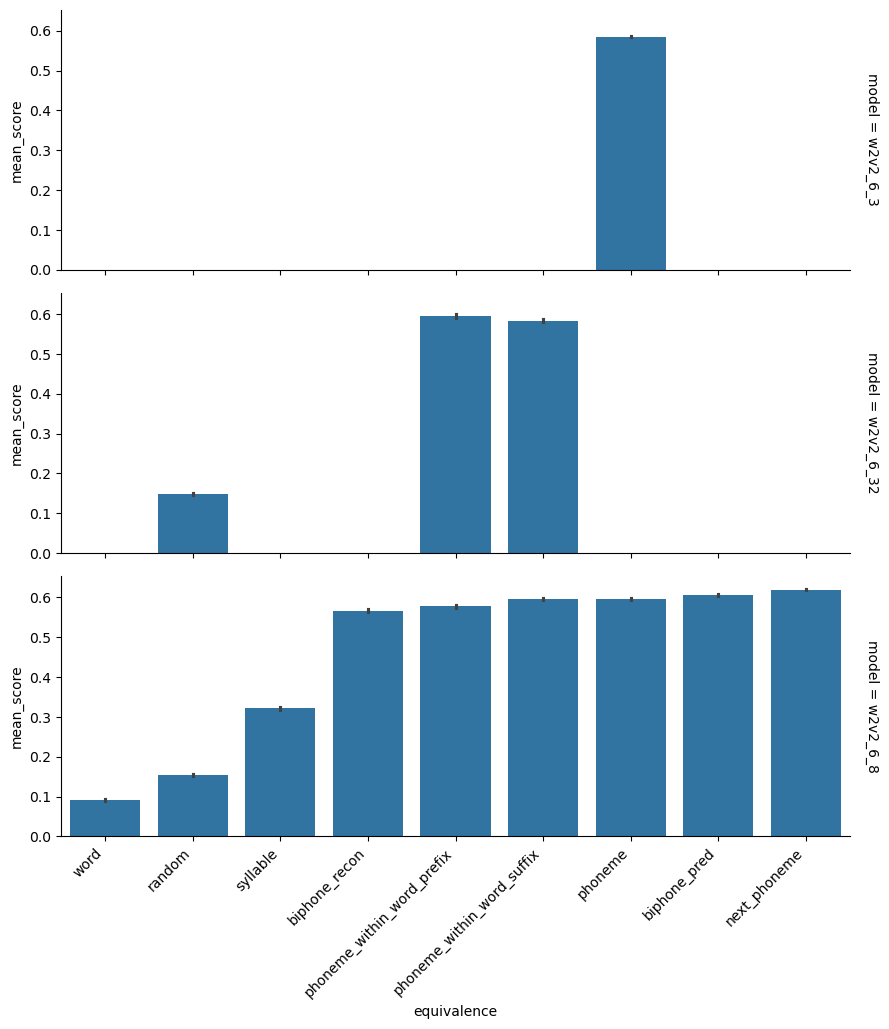

In [110]:
g = sns.FacetGrid(data=score_summary.reset_index(), row="model", margin_titles=True, aspect=3)
g.map(sns.barplot, "equivalence", "mean_score", order=score_summary.groupby("equivalence").mean().sort_values("mean_score").index, errorbar="se")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

## Feature selection results

In [130]:
feature_selection_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_feature_selection_trajectory.csv"))
feature_selection = pd.concat([pd.read_csv(p) for p in feature_selection_paths],
                              keys=[(p.parents[2].name, p.parents[1].name) for p in feature_selection_paths],
                              names=["model", "equivalence"])

# feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

feature_selection.index.set_names("selection_idx", level=-1, inplace=True)
feature_selection = feature_selection.sort_index().reset_index()
feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

# Compute score deltas
feature_selection["score_diff"] = feature_selection.score.diff()
# Correct for boundaries
feature_selection.loc[feature_selection.selection_idx == 0, "score_diff"] = 0

feature_selection.head(10)

,model,equivalence,selection_idx,Unnamed: 0,category,score,score_diff
0,w2v2_6_32,random,0,0,NaN,0.017284,0.000000
1,w2v2_6_32,random,1,1,consonant_manner,0.072362,0.055078
2,w2v2_6_32,random,2,2,consonant_place,0.108654,0.036291
3,w2v2_6_32,random,3,3,vowel,0.128176,0.019522
4,w2v2_6_8,random,0,0,NaN,0.015372,0.000000
5,w2v2_6_8,random,1,1,consonant_place,0.080950,0.065578
6,w2v2_6_8,random,2,2,consonant_manner,0.114248,0.033298
7,w2v2_6_8,random,3,3,vowel,0.133393,0.019145
8,w2v2_6_32,random,0,0,NaN,0.019205,0.000000
9,w2v2_6_32,random,1,1,consonant_manner,0.099420,0.080214


In [131]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

plot_data = feature_selection[(feature_selection.model == "w2v2_6_8")]
plot_data["category"] = plot_data.category.fillna("baseline")

/tmp/ipykernel_2576711/3410982662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["category"] = plot_data.category.fillna("baseline")


In [132]:
links = []
for (model, equivalence), rows in plot_data.groupby(["model", "equivalence"]):
    for i1, i2 in zip(rows.index, rows.index[1:]):
        links.append({"source": rows.loc[i1].category, "target": rows.loc[i2].category, "value": rows.loc[i2, "score_diff"],
                      "type": f"{model} {equivalence}"})

layout = Layout(width="1500", height="1200")
SankeyWidget(links=links, linkLabelFormat=".2f", layout=layout)

SankeyWidget(layout=Layout(height='1200', width='1500'), linkLabelFormat='.2f', links=[{'source': 'baseline', …